In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg
from scipy import fft

import sys
sys.path.insert(0,'..')
import specsens as ss

In [41]:
def mme_thr(Ns, L, Pfa=0.1, M=1):
    tw = ss.TracyWidom(beta=1)
    fac1 = (np.sqrt(Ns)+np.sqrt(M*L))**2/(np.sqrt(Ns)-np.sqrt(M*L))**2
    fac2 = 1+((np.sqrt(Ns)+np.sqrt(M*L))**(-2/3)/(Ns*M*L))*tw.cdfinv(1-Pfa) 
    return fac1*fac2

def eme_thr(Ns, L, Pfa=0.1, M=1):
    fac1 = np.sqrt(2./(M*Ns))*stats.norm.isf(Pfa)+1
    fac2 = Ns/(np.sqrt(Ns)-np.sqrt(M*L))**2
    return fac1*fac2


def corr(x, l):
    x = np.reshape(x, (-1, 1))
    r = np.zeros((l, l), dtype = np.complex128)
    for i in range(0, len(x)-l):
        r += np.dot(x[i:i+l], x[i:i+l].conj().T)
    return r / (len(x)-l)

def mme(x, l=10):
    Rx = corr(x, l)
    eigvals = np.abs(linalg.eigvals(Rx))
    return np.max(eigvals) / np.min(eigvals)

def eme(x, l=10):
    Rx = corr(x, l)
    eigvals = np.abs(linalg.eigvals(Rx))
    energy = np.sum(np.abs(x)**2.) / len(x)
    return energy / np.min(eigvals)


print('Pfa mme:', mme_thr(Ns=10000, L=10, Pfa=0.1, M=0.976))
print('Pfa mme:', mme_thr(Ns=10000, L=10, Pfa=0.1, M=0.99))
print('Pfa mme:', mme_thr(Ns=10000, L=10, Pfa=0.1, M=1.))
print('Pfa eme:', eme_thr(Ns=10000, L=10, Pfa=0.1, M=1.))

Pfa mme: 1.1331539865978912
Pfa mme: 1.1341674142509173
Pfa mme: 1.134887469339676
Pfa eme: 1.085704130251417


---- Simulation parameters ----
Generations:    100
Iterations:     100
Total Iters:    10000
Signal power:   0.00 dB
Noise power:    20.00 dB
Noise uncert.:  0.00 dB
SNR:            -20.00 dB
Signal length:  0.010000 sec
Signal samples: 10000
---- Simulation stats theory ----
---- Running simulation ----
   infs left at  0.00%
456.94s left at  1.00%
464.42s left at  2.00%
499.11s left at  3.00%
449.34s left at  4.00%
473.84s left at  5.00%
458.10s left at  6.00%
459.09s left at  7.00%
480.78s left at  8.00%
445.12s left at  9.00%
422.84s left at 10.00%
424.51s left at 11.00%
433.30s left at 12.00%
442.95s left at 13.00%
421.45s left at 14.00%
433.25s left at 15.00%
392.45s left at 16.00%
407.78s left at 17.00%
410.89s left at 18.00%
445.95s left at 19.00%
442.07s left at 20.00%
427.71s left at 21.00%
371.74s left at 22.00%
359.40s left at 23.00%
353.89s left at 24.00%
352.62s left at 25.00%
352.68s left at 26.00%
346.69s left at 27.00%
333.70s left at 28.00%
336.70s left at 29.00%
325

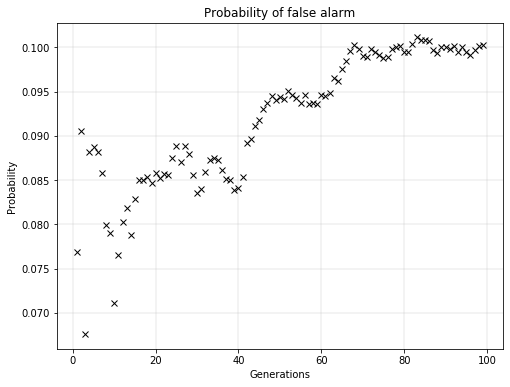

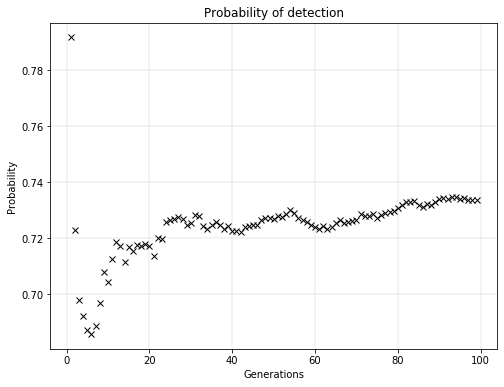

In [42]:
def sim_eigenvalue(gens=100,
                   itrs=100,
                   f_sample=1e6,
                   signal_power=0.,
                   noise_power=0.,
                   length_sec=None,
                   num_samples=None,
                   theo_pfa=0.1,
                   threshold=None,
                   noise_un=0.):

    # Check and calculate length, in seconds and number of samples
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    print('---- Simulation parameters ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total Iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_power))
    print('Noise power:    %.2f dB' % (noise_power))
    print('Noise uncert.:  %.2f dB' % (noise_un))
    print('SNR:            %.2f dB' % (signal_power - noise_power))
    print('Signal length:  %.6f sec' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    
    print('---- Simulation stats theory ----')
#     print('Prob false alarm %.4f' % (theo_pfa))
#     print('Prob detection   %.4f' % (theo_pd))
#     print('Threshold        %.4f' % (threshold))

    print('---- Running simulation ----')

    pfas = list()  # Probability of false alarm list
    pds = list()  # Probability of detection list
    current_time = None

    # Create new signal objects
    wm = ss.WirelessMicrophone(f_sample=f_sample, t_sec=length_sec)
    wgn = ss.WhiteGaussianNoise(f_sample=f_sample, t_sec=length_sec)

    # Outer generations loop
    for i in range(gens):

        # Run itertations and store results in result array
        result = np.array([])
        for j in range(itrs):
                
            # Generate signal, center frequency does not matter with single band ED
            sig = wm.get_soft(f_center=1e5, power=signal_power, dB=True)

            # Generate noise
            noise = wgn.get_signal(power=noise_power, dB=True)

            # Randomly decide whether signal should be present
            sig_present = bool(np.random.randint(2))
            if sig_present:
                both = sig + noise
            else:
                both = noise
            
            test_statistic = statistic(both)
            
            # Threshold
            sig_detected = test_statistic > 1.1331539865978912

            # Log signal and detection outcome
            if sig_present and sig_detected:
                result = np.append(result, 1)
            elif sig_present and not sig_detected:
                result = np.append(result, 2)
            elif not sig_present and sig_detected:
                result = np.append(result, 3)
            else:
                result = np.append(result, 4)
            
#             print(test_statistic, sig_detected, sig_present)
    
        # Convert to numpy array
        result = np.asarray(result)

        # Calculate statistics and store in arrays
        pfa_tmp = np.sum(result == 3) / (np.sum(result == 3) + np.sum(result == 4))
        pd_tmp = np.sum(result == 1) / (np.sum(result == 1) + np.sum(result == 2))
        pfas.append(pfa_tmp)
        pds.append(pd_tmp)

        # Print simulation progress
        rem, percent, current_time = ss.util_sim.runtime_stats(current_time, gens, i)
        print('%6.2fs left at %5.2f%%' % (rem, percent))

    # Compute stats from lists
    pfa = np.sum(pfas) / gens
    pd = np.sum(pds) / gens

    print('---- Simulation stats ----')
#     print('Prob false alarm theory %.4f' % (theo_pfa))
    print('Prob false alarm sim    %.4f' % (pfa))
#     print('Prob detection theory   %.4f' % (theo_pd))
    print('Prob detection sim      %.4f' % (pd))

    ss.util_sim.print_convergence(gens, pfas, pds)
    return pfa, pd


_ = sim_eigenvalue(
    gens=100,
    itrs=100,
    f_sample=1e6,  # in Hz
    signal_power=0.0,  # in dB
    noise_power=20.0,  # in dB
    length_sec=0.010000,  # in seconds
    theo_pfa=0.1,  # probability of false alarm
    threshold=None,
    noise_un=0.0)  # standard deviation of the noise normal distribution